In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

import warnings
warnings.filterwarnings('ignore')

In [11]:
data = pd.read_csv('fraud_oracle.csv')

In [12]:
data.isnull().values.any()

np.False_

## Checking for multicollinearity

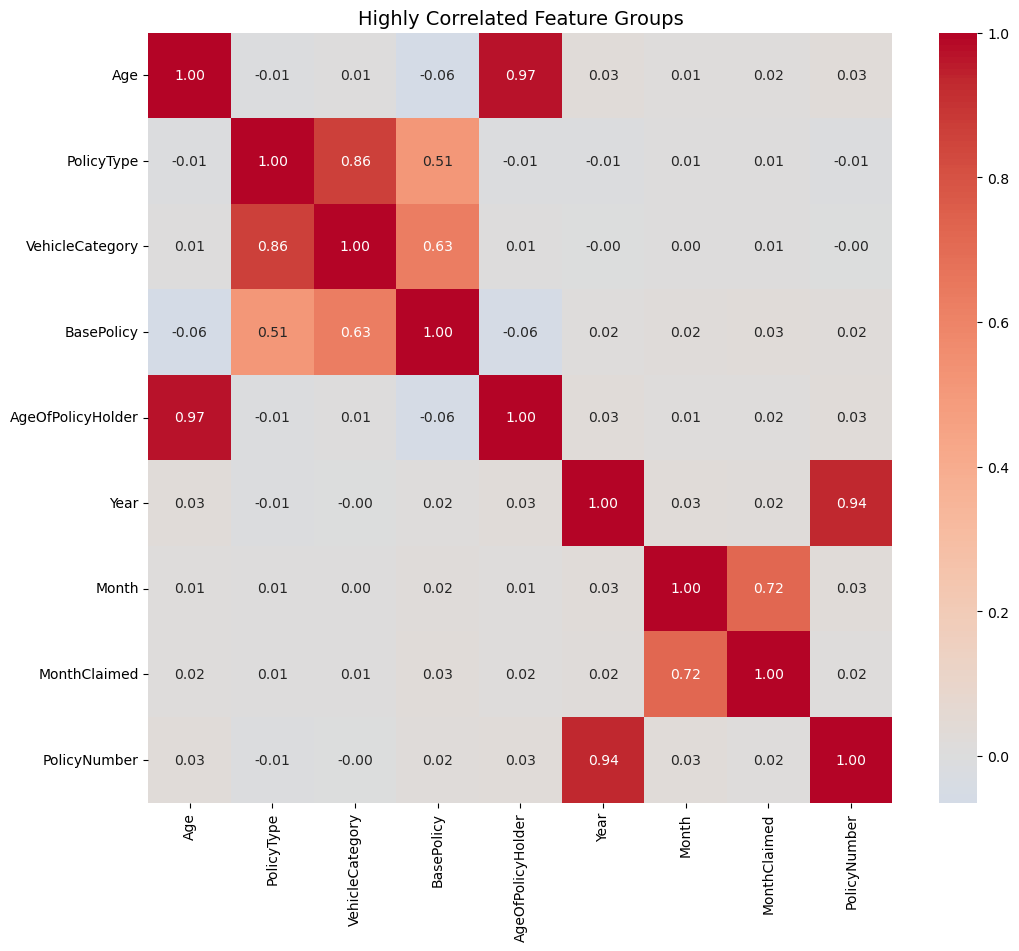

In [13]:
from sklearn.preprocessing import LabelEncoder

data_encoded = data.copy()

for col in data_encoded.select_dtypes(include=['object', 'category']):
    data_encoded[col] = LabelEncoder().fit_transform(data_encoded[col])

features_only = data_encoded.drop(columns=["FraudFound_P"])
corr_matrix = features_only.corr()

corr_pairs = (corr_matrix.abs().unstack().sort_values(ascending=False))

# Removing self-correlation
corr_pairs = corr_pairs[corr_pairs < 1.0]

# Only strong correlations
strong_corr = corr_pairs[corr_pairs >= 0.6]

high_corr_features = list(set([i for i, j in strong_corr.index] + [j for i, j in strong_corr.index]))

plt.figure(figsize=(12, 10))
sns.heatmap(features_only[high_corr_features].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Highly Correlated Feature Groups", fontsize=14)
plt.show()

## Feature Selection

In [14]:
drop_columns = ["PolicyNumber", "Year", "RepNumber", "NumberOfSuppliments", "BasePolicy", "VehicleCategory", "Age", "NumberOfSuppliments", "DayOfWeekClaimed", "WeekOfMonthClaimed", "MonthClaimed"]

data.drop(columns=drop_columns, inplace=True)

In [15]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'Sex',
       'MaritalStatus', 'Fault', 'PolicyType', 'VehiclePrice', 'FraudFound_P',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'AddressChange_Claim', 'NumberOfCars'],
      dtype='object')

## Train-Test Split

In [16]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='FraudFound_P', axis=1)
y = data['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

(15420, 22) (12336, 22) (3084, 22)


## Data Preprocessing

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fitting only on training data
preprocessor.fit(X_train)

# Transforming both train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# Saving preprocessor for deployment
joblib.dump(preprocessor, "data-preprocessor.pkl")

['data-preprocessor.pkl']


## Data Balancing using SMOTE

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.5, random_state=123)
X_res, y_res = smote.fit_resample(X_train_processed, y_train)

## Model Training

### Ensemble with Soft Voting

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

import xgboost as xgb

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

estimators = [
    ('lr', LogisticRegression(class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)),
    ('xgb', xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)),
    ('cat', CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6, class_weights=[1, 10], random_seed=42, verbose=0))
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),  # meta-model
    cv=5,
    passthrough=True  # passes base features to meta-model
)

stack_model.fit(X_res, y_res)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(class_weight='balanced',
                                                   random_state=42)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001FC282E63C0>)],
                   final_estimator=LogisticRegression(), passthrough=True)

### Model Evaluation

In [21]:
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, average_precision_score)

# Predictions
y_pred = stack_model.predict(X_test_processed)
y_pred_proba = stack_model.predict_proba(X_test_processed)[:, 1]  # probability of class 1 (fraud)

pr_auc = average_precision_score(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.17      0.01      0.01       185

    accuracy                           0.94      3084
   macro avg       0.55      0.50      0.49      3084
weighted avg       0.89      0.94      0.91      3084

Confusion Matrix:
 [[2894    5]
 [ 184    1]]
ROC-AUC: 0.5874
PR-AUC: 0.0968


In [22]:
# Saving the model
joblib.dump(stack_model, 'stack-model.pkl')

['stack-model.pkl']